# Extreme learning machines
***
*Universidade Federal de Minas Gerais*  
*Introdução à Inteligência Computacional*  
*Autores: Álvaro Lemos e Felipe Carvalho*

## ELM theory



## EML implementation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#loading datasets
from sklearn.datasets import load_boston, load_breast_cancer, load_diabetes, fetch_california_housing

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

#loading linear models for the output layer of the ELM
from sklearn.linear_model import ElasticNet, Lasso, Ridge, LinearRegression
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron

#misc functions from sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn.grid_search import ParameterGrid
from sklearn.metrics import accuracy_score, mean_squared_error

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
#Activation functions for the hidden layer of the ELM

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def relu(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)

In [3]:
class ELMRegressor:

    def __init__(self, n_hidden, regularizer = None, alpha = 1.0, **kwargs):
        self.n_hidden = n_hidden
        self.alpha = alpha
        self.activation_func = sigmoid

        if regularizer:
            self.regularizer = regularizer.lower()
        else:
            self.regularizer = regularizer

        if not self.regularizer:
            self.model = LinearRegression(n_jobs=-1)
        elif self.regularizer == 'lasso' or self.regularizer == 'l1':
            self.model = Lasso(alpha=self.alpha, **kwargs)
        elif self.regularizer == 'ridge' or self.regularizer == 'l2':
            self.model = Ridge(alpha=self.alpha, **kwargs)
        elif self.regularizer == 'elasticnet' or self.regularizer == 'l1l2':
            self.model = ElasticNet(alpha=self.alpha, **kwargs)
        else:
            raise ValueError('{} regularization invalid'.format(self.regularizer))

    def _initialize_hidden_layer(self, X):
        n_samples, n_features = X.shape
        self.W_ = np.random.randn(n_features, self.n_hidden)


    def _project_features(self, X):
        G = self.activation_func(np.dot(X, self.W_))
        return G


    def fit(self, X, y):
        self._initialize_hidden_layer(X)
        G = self._project_features(X)
        self.model.fit(G, y)    
    
    
    def predict(self, X):
        G = self._project_features(X)
        return self.model.predict(G)

In [4]:
def get_boston_dataset():
    boston = load_boston()
    X = pd.DataFrame(boston.data, columns=boston.feature_names)
    X = one_hot_encode_column(X, 'CHAS')
    y = boston.target.reshape(-1, 1)
    return X, y


def get_breast_cancer():
    breast = load_breast_cancer()
    X = pd.DataFrame(breast.data, columns=breast.feature_names)
    y = breast.target.reshape(-1, 1)
    return X, y


def get_diabetes():
    diabetes = load_diabetes()
    X = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
    y = diabetes.target.reshape(-1, 1)
    return X, y


def get_auto_mpg():
    auto_mpg = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data',
                           delim_whitespace=True,
                           header=None)
    auto_mpg = auto_mpg[auto_mpg.iloc[:, 3] != '?']

    X = auto_mpg.iloc[:, 1:8]
    y = auto_mpg.iloc[:, 0].values.reshape(-1, 1)

    return X, y


def one_hot_encode_column(X, col):
    chas_encoded = LabelEncoder().fit_transform(X[col]).reshape(-1, 1)
    chas_dummy = OneHotEncoder(sparse=False).fit_transform(chas_encoded)
    return pd.concat([X.drop(col, axis=1), pd.DataFrame(chas_dummy)], axis=1)

In [5]:
def train_val_split(X, y, train_index, val_index):
    X_train = X.iloc[train_index, :]
    X_val = X.iloc[val_index, :]
    y_train = y[train_index, :]
    y_val = y[val_index, :]

    return X_train, X_val, y_train, y_val    

In [6]:
datasets = [
    ('Boston Housing', get_boston_dataset),
    ('Breast Cancer', get_breast_cancer),
    ('Diabetes', get_diabetes),
    ('Auto MPG', get_auto_mpg)
]

models = [
    {
        'name': 'ELM',
        'model': ELMRegressor,
        'regularization': None,
        'grid': { 'n_hidden': [100, 500, 1000] }
    },

    {
        'name': 'ELM Ridge',
        'model': ELMRegressor,
        'regularization': 'ridge',
        'grid': { 'alpha': [0.001, 0.01, 0.1, 1], 'n_hidden': [100, 500, 1000] }
    },

    {
        'name': 'ELM Lasso',
        'model': ELMRegressor,
        'regularization': 'lasso',
        'grid': { 'alpha': [0.001, 0.01, 0.1, 1], 'n_hidden': [100, 500, 1000] }
    },

    {
        'name': 'ELM ElasticNet',
        'model': ELMRegressor,
        'regularization': 'ridge',
        'grid': { 'alpha': [0.001, 0.01, 0.1, 1], 'n_hidden': [100, 500, 1000] }
    }
]

In [7]:
np.random.seed(0)

results = []

for dataset_name, dataset_getter in datasets:
    X, y = dataset_getter()
    X_cv, X_test, y_cv, y_test = train_test_split(X, y)

    for model_info in models:
        param_grid = ParameterGrid(model_info['grid'])

        grid_results = []
        for params in param_grid:

            kf = KFold(n_splits=5, random_state=1)
            rmses = []
            for train_index, val_index in kf.split(X_cv):
                X_cv_train, X_cv_val, y_cv_train, y_cv_val = \
                    train_val_split(X_cv, y_cv, train_index, val_index)

                scaler = StandardScaler()
                scaler.fit(X_cv_train)
                X_cv_train = scaler.transform(X_cv_train)
                X_cv_val = scaler.transform(X_cv_val)

                model = model_info['model'](regularizer=model_info['regularization'], **params)
                model.fit(X_cv_train, y_cv_train)
                y_cv_pred = model.predict(X_cv_val)
                rmse = np.sqrt(mean_squared_error(y_cv_val, y_cv_pred))
                rmses.append(rmse)

            grid_results.append((np.mean(rmses), params))

        scaler = StandardScaler()
        scaler.fit(X_cv)
        X_cv_scaled = scaler.transform(X_cv)
        X_test_scaled = scaler.transform(X_test)
        best_params = sorted(grid_results, key=lambda result: result[0])[0][1]

        best_params_results = []
        for _ in range(5):
            model = model_info['model'](regularizer=model_info['regularization'], **best_params)
            model.fit(X_cv_scaled, y_cv)
            y_pred = model.predict(X_test_scaled)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            best_params_results.append(rmse)
        best_mean_rmse = np.mean(best_params_results)

        if model_info['name'] == 'ELM':
            best_alpha = '-'
        else:
            best_alpha = best_params['alpha']
        best_n_hidden = best_params['n_hidden']

        results.append((dataset_name, model_info['name'], best_mean_rmse, best_n_hidden, best_alpha))


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [10]:
results_df = pd.DataFrame(results, columns=['Dataset', 'Model', 'RMSE', 'Best # Nodes', 'Best alpha'])
results_df

,Dataset,Model,RMSE,Best # Nodes,Best alpha
0,Boston Housing,ELM,5.895330,100,-
1,Boston Housing,ELM Ridge,4.356577,1000,1
2,Boston Housing,ELM Lasso,4.267061,1000,0.01
3,Boston Housing,ELM ElasticNet,4.605461,500,0.1
4,Breast Cancer,ELM,0.217447,1000,-
5,Breast Cancer,ELM Ridge,0.174173,100,1
6,Breast Cancer,ELM Lasso,0.156323,1000,0.01
7,Breast Cancer,ELM ElasticNet,0.188767,1000,1
8,Diabetes,ELM,63.008420,100,-
9,Diabetes,ELM Ridge,58.910897,100,1


/usr/local/lib/python3.5/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


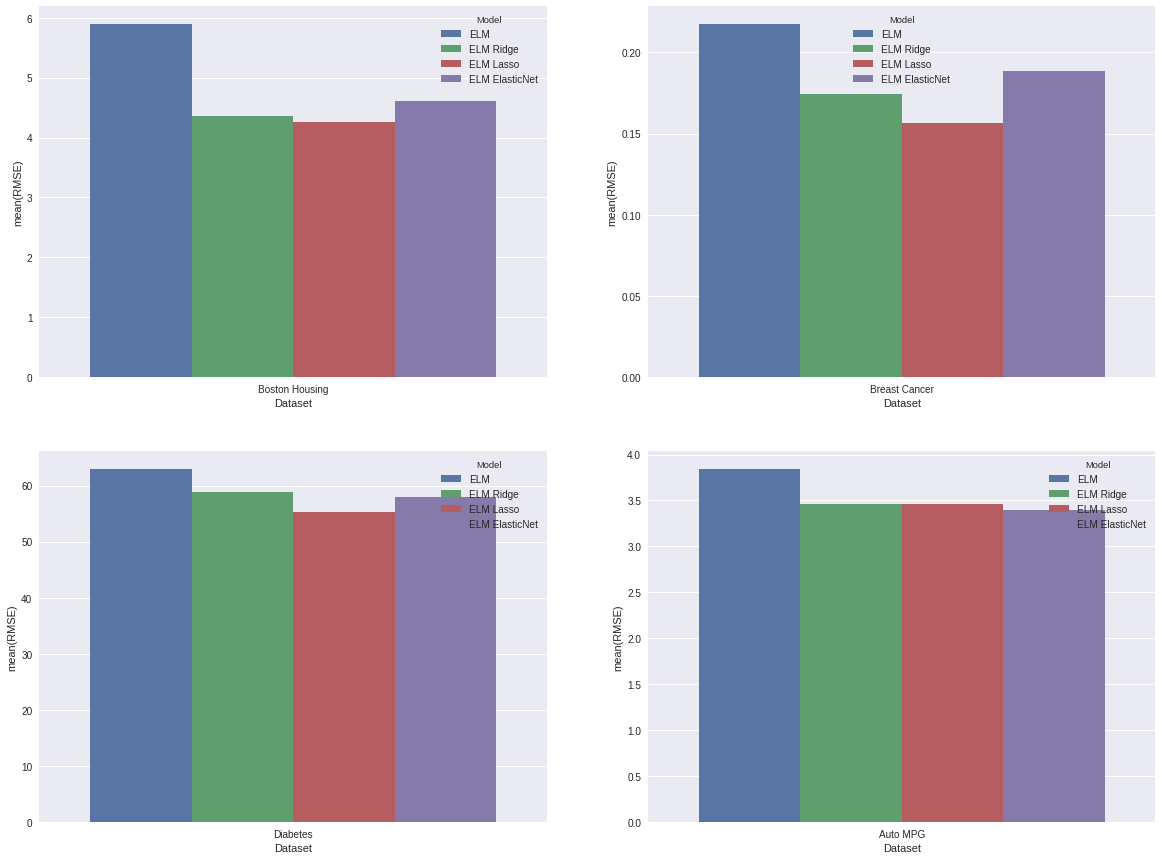

In [24]:
plt.figure(figsize=(20, 15))
for i, dataset in enumerate(results_df['Dataset'].unique()):
    plt.subplot(2, 2, i + 1)
    mask = results_df['Dataset'] == dataset
    sns.barplot(x='Dataset', y='RMSE', hue='Model', data=results_df[mask])
plt.show()